#### See the output of the last cell

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

%run assignment1_modules.ipynb

In [2]:
def sgd_momentum(x, dx, config, state):
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

In [3]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
else:
    mnist = fetch_mldata("mnist-original")
    X = mnist.data / 255.0
    np.savez('mnist.npz', X=X)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size = 0.2)

In [5]:
criterion = MSECriterion()

net = Sequential()
net.add(Linear(784, 250))
net.add(ReLU())
net.add(Linear(250, 128))
net.add(ReLU())

net.add(Linear(128, 30))
net.add(ReLU())
net.add(Linear(30, 128))
net.add(ReLU())
net.add(Linear(128, 250))
net.add(ReLU())

net.add(Linear(250, 784))

In [6]:
# Optimizer params
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 25
batch_size = 200

In [7]:
# batch generator
def get_batches(X, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx]

In [8]:
for i in range(n_epoch):
    
    start=time()
    for x_batch in get_batches(X_train, batch_size):
#         print(x_batch)
        
        # Forward
        predictions = net.forward(x_batch)
#         print(predictions)
        loss = criterion.forward(predictions, x_batch)
        # Backward
        dp = criterion.backward(predictions, x_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
    
    display.clear_output(wait=True)
    print("Step: "+str(i))
    print("Loss: "+str(loss))
    print("ETA: "+str((n_epoch-i)*(time()-start)/60)+" min")

#         break
#     break

Step: 24
Loss: 13.6513575861
ETA: 0.12754878203074138 min


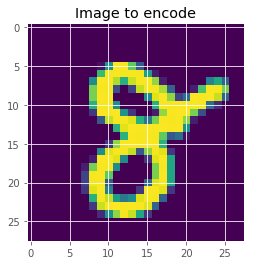

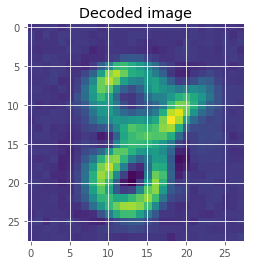

In [9]:
plt.imshow(X_test[1].reshape(28, -1))
plt.title("Image to encode")
plt.show()
plt.imshow(net.forward(np.array([X_test[1]]))[0].reshape(28, -1))
plt.title("Decoded image")
plt.show()